As a fan of soccer it is accepted that starters will be rotated/rested to keep the best players fresh for the more *important* matches.  In soccer those are easier to define: some cup games are much less important than say, fighting for a top four finish, or advancing in the Champions League. <br>
So what about baseball? A MLB season is long, and each game could in theory last forever.  Players work six days a week for six (or seven) months, usually only missing days for injuries. But are some matchups more important than others, and is there any benefit in resting players to be fresh for those games$^{\dagger}$?
To answer that, I put together a simple(ish) simulation to look for improvement in playoff odds for teams that stack their chances of winning when playing teams in their division.  
I start with the assumption that outcomes are well approximated as weighted coin flips, where the weight is a combination of the win/loss record of the teams in question, plus a nudge factor that is positive against division rivals, a little less positive against league rivals, and negative in interleague, with the sum of all nudges equal to zero. <br>
Thus, my intention is to investigate whether the odds of making the playoffs increases if we manipulate the odds of winning "high value" games by nudging their outcomes, and see if this might be a good strategy. 

$^{\dagger}$ setting aside whether players will go for it; times change, attitudes adapt, case in point: openers.

## Algorithm

To quantify the effect of shifting weights on playoff odds, we need a way to simulate entire seasons simply and quickly, with enough simulations to separate signal from noise. 
The simulation will be built around Python **Classes** for Teams and Seasons.  <br>

The details of how we define and apply "nudge's" makes all the difference.  Here we add 2\times the nudge factor for division rivals, 1\times the nudge factor for league rivals, and none for inter-league.  Furthermore, we normalize so that nudges are a zero-sum manipulation; i.e., to play better in some games, you have to give something up in others.   
<br>

Required data:
1. Lahman Database to estimate each teams true-talent [in sqlite from jknecht's Github](https://github.com/jknecht/baseball-archive-sqlite)
2. Retrosheet Schedule.  https://www.retrosheet.org/schedule/

Steps: 
1. Import a schedule
2. Import season stats to infer true-talent
3. Specify simulation details
4. Run simulation over N seasons 
5. Determine simulation rankings
6. Analyze outcomes

## Python packages
We start by importing some standard Python packages.  

In [4]:
# For mac users with Retina display
%config InlineBackend.figure_format = 'retina' 
# OS
import os, subprocess
import os.path
# Numpy
import numpy as np; print("  numpy:", np.__version__)
# Scipy
import scipy as sp; print("  scipy:", sp.__version__)
import scipy.stats as stats
from scipy.optimize import curve_fit
# Pandas 
import pandas as pd; print("  pandas:", pd.__version__)
# Seaborn is for improved plotting style
import seaborn as sns; print("  seaborn:", sns.__version__)
# Sci-kit Learn
import sklearn; print("  scikit-learn:", sklearn.__version__)
# SQL 
import sqlite3

# Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import pdb

  numpy: 1.16.4
  scipy: 1.3.0
  pandas: 0.25.0
  seaborn: 0.9.0
  scikit-learn: 0.21.2


We use seaborn to improve the look of the figures, and matplotlib inline to see the figures in the cells.

# Tools   

#### Simulate Wins/Losses as weighted coin flip using the binomial distribution, where the mean is estimated using the win/loss records of the opposing teams.

In [5]:
def weighted_coin_flip(vt_truetalent, ht_truetalent, homefieldadv = 0.04, vt_nudge = 0.0, ht_nudge = 0.0, number_flips=1):
    ''' Estimate win or loss based on combination of true talent of both teams, and random chance. '''
    
    # Effective True Talent can be nudged up or down if say, starting pitcher is the ace, or sitting best players for rest.
    eff_vt = vt_truetalent * (1 + vt_nudge);
    eff_ht = ht_truetalent * (1 + ht_nudge);
    
    # Combine effective weights (plus home field advantage) with team true talents to estimate effective probabililty.
    effective_weighted_probability = eff_ht * (1 - eff_vt) / ((1 - eff_ht) + (1 - eff_vt)) * (1 + homefieldadv)

    # Return estimate of a binomial distribution with effective probability.  
    return np.random.binomial(1, effective_weighted_probability, number_flips)

#### Import Retrosheet schedule for given year

In [17]:
def import_retrosheet_schedule(year = 2016, retrosheet_path = '/data/baseball/Retrosheet/'):
    '''Import Retrosheet schedule and store into a Pandas DataBase'''
    
    #Check that file exists.  
    file_retrosheet_schedule = '{0}SKED.TXT'.format(year)
    os.path.isfile(retrosheet_path+file_retrosheet_schedule)
    
    # Read CSV and name columns manually.
    sched_df = pd.read_csv(retrosheet_path+file_retrosheet_schedule)
    cols = ['date','num_games','day_of_week','vt','league_vt','game_number_vt','ht','league_ht','game_number_ht','time','postpone','makeupdate']
    sched_df.columns = cols
    
    return sched_df

#### Determine Standings for one season simulation, given schedule and previous records. 

In [6]:
def single_season_standings(schedule, seasons = 1):
    ''' 
    Input MLB Season Schedule and use weighted_coin_flip (a wrapper for the Binomial Distribution) to Estimate Wins/Losses.
    
    Returns dictionary matchups, which for each team contains an array with:
        0 - date
        1 - visiting team (vt)
        2 - home team (ht)
        3 - home team outcome (win = 1, loss = 0)
    for each game in the season.
    '''   
    
    # Dictionary to store matchups.
    matchups = {}
    
    # Assume a 4% home field advantage 
    home_field_advantage = 0.04 
    
    # Loop over every game in schedule. 
    for index in range(len(schedule.matchups)):

        # Extract row
        row = schedule.matchups.iloc[index]
        date = row.date
        
        # Store visiting and home team ID
        vt = row.vt
        ht = row.ht
        
        # Use real data to estimate their true talent.  
        vt_truetalent = schedule.wins[row.vt] / 162. 
        ht_truetalent = schedule.wins[row.ht] / 162. 
        
        # Extract nudge values from schedule.
        vt_nudge = row.vt_nudge
        ht_nudge = row.ht_nudge
        
        # Estimate game-winner based on true-talent + nudges.  
        ht_win = weighted_coin_flip(vt_truetalent, ht_truetalent, home_field_advantage, vt_nudge = vt_nudge, ht_nudge = ht_nudge, number_flips=seasons)
        
        # Store results in matchups
        if ht in matchups.keys():
            matchups[ht] = matchups[ht].append(pd.DataFrame([[date, vt, ht, ht_win]], columns = ['date','visiting_team','home_team', 'win']))
        else:
            matchups[ht] = pd.DataFrame([[date, vt, ht, ht_win]], columns = ['date','visiting_team','home_team', 'win'])
            
        if vt in matchups.keys():
            matchups[vt] = matchups[vt].append(pd.DataFrame([[date, vt, ht, abs(1 - ht_win)]], columns = ['date','visiting_team','home_team', 'win']))
        else:
            matchups[vt] = pd.DataFrame([[date, vt, ht, abs(1 - ht_win)]], columns = ['date','visiting_team','home_team', 'win'])
    
    return matchups

#### Determine schedule, and implement nudge factors based on specified conditions, etc., if playing division rival, or inter-league.  

In [7]:
class team_schedules:
    '''Store Team Schedules and Nudge Values'''
    
    def __init__(self, sched_df):
        
        # Hard-code Leagues and Divisions 
        AL = {}
        NL = {}
        MLB = {"NL":NL,"AL":AL}
        AL['East']    = ['NYA','TOR','BOS','BAL','TBA']
        AL['Central'] = ['CHA','KCA','CLE','MIN','DET']
        AL['West']    = ['OAK','ANA','HOU','TEX','SEA']
        NL['East']    = ['NYN','ATL','MIA','WAS','PHI']
        NL['Central'] = ['CHN','MIL','CIN','PIT','SLN']
        NL['West']    = ['LAN','SDN','SFN','ARI','COL']
        self.leagues = MLB 
        self.teams = {"NL":np.unique(sched_df[sched_df.league_ht == 'NL'].ht), "AL":np.unique(sched_df[sched_df.league_ht == 'AL'].ht)}
        self.matchups = pd.DataFrame(columns = ['date','ht','vt','rivalry_level','ht_nudge','vt_nudge'])
        self.wins = {}

        # Store Schedules into Matchups DataFrame
        for league in self.leagues:
            for team in self.teams[league]:
                self.matchups = self.matchups.append(sched_df[sched_df.ht == team][['date','ht','vt']],sort=False)
        
        # Call Rivalry level setter (inter-division, etc.)
        self.define_rivalry_level()
        
    # Store Real-Life Wins for later estimate of true-talent
    def get_wins(self, ttt):
        for league in self.leagues:
            for team in self.teams[league]:
                self.wins[team] = ttt[ttt.teamID == team].W.values[0]
    
    # Set the Rivalry level (inter-division, etc.)
    def define_rivalry_level(self):
        '''Determine whether contest is inter-division (rivalry_level=2), inter-league (rivalry_level=1), or out of league (rivalry_level=0)'''
        for league in self.leagues:
            for team in self.teams[league]:
                idx_ht = self.matchups[self.matchups.ht == team].index
                for home_game_id in idx_ht:
                    rival = pd.DataFrame(self.leagues[league]).isin(self.matchups[['vt','ht']].loc[home_game_id].values)
                    self.matchups['rivalry_level'].loc[home_game_id] = rival.sum().max() + rival.sum().sum() - 2
    
    # Set the Nudge level.  
    def set_nudge_level(self, nudge_lvl, zero_sum = True):
        '''Set the nudge level by multiplication nudge_lvl and rivalry_level'''
        for team in nudge_lvl:
            for i, n in zip(['ht','vt'], ['ht_nudge','vt_nudge']):
                idx_tm = self.matchups[self.matchups[i] == team].index
                nudge_array = self.matchups.loc[idx_tm]['rivalry_level'] * nudge_lvl[team]
                if zero_sum == True:
                    self.matchups[n].loc[idx_tm] = (nudge_array - sum(nudge_array)/len(nudge_array))
                else:
                    self.matchups[n].loc[idx_tm] = nudge_array
        
        self.matchups = self.matchups.fillna(0)

#### Use sqlite and the Lahman database to get prior estimates of team records.  

In [8]:
class team_wins:
    '''Read the Lahman sqlite file and Pull Wins'''
    def __init__(self, year = 2016, path_lahman_sqlite = '/Users/marcoviero/Code/Python/Modules/git_repositories/baseball-archive-sqlite/'):
        
        file_lahman_sqlite = path_lahman_sqlite+'lahman{0}.sqlite'.format(year)
        if os.path.isfile(file_lahman_sqlite) == False:
            print('No File in '+file_lahman_sqlite)

        # Connecting to SQLite Database
        conn = sqlite3.connect(file_lahman_sqlite)
        # Querying Database for all seasons where a team played 150 or more games and is still active today. 
        query = '''
            select * from Teams
            inner join TeamsFranchises
            on Teams.franchID == TeamsFranchises.franchID
            where Teams.G >= 150 and TeamsFranchises.active == 'Y';
        '''
        
        # Creating dataframe from query.
        Teams = conn.execute(query).fetchall()
        teams_df = pd.DataFrame(Teams)
        cols = ['yearID','lgID','teamID','franchID','divID','Rank','G','Ghome','W','L','DivWin','WCWin','LgWin','WSWin','R','AB','H','2B','3B','HR','BB','SO','SB','CS','HBP','SF','RA','ER','ERA','CG','SHO','SV','IPouts','HA','HRA','BBA','SOA','E','DP','FP','name','park','attendance','BPF','PPF','teamIDBR','teamIDlahman45','teamIDretro','franchID','franchName','active','NAassoc']
        teams_df.columns = cols
        teams_df['teamID'] = teams_df['teamID'].replace({"LAA":"ANA"}) 
        drop_cols = ['lgID','franchID','divID','Rank','Ghome','L','DivWin','WCWin','LgWin','WSWin','SF','name','park','attendance','BPF','PPF','teamIDBR','teamIDlahman45','teamIDretro','franchID','franchName','active','NAassoc']
        df = teams_df.drop(drop_cols, axis=1)
        self.winning_percentage = df.loc[df.yearID == year,['teamID','W']]
        self.winning_percentage['true_talent'] = self.winning_percentage['W']/162.

#### Put all the tools together in season simulator

In [9]:
class simulate_season:
    '''Simulate every game, store results, and create standings'''
    
    def __init__(self, schedule_df, num_seasons = 1, year = 2016, 
                 path_lahman_sqlite = '/Users/marcoviero/Code/Python/Modules/git_repositories/baseball-archive-sqlite/', 
                 zero_sum = True, team_nudges = 0): 
        '''The following file containing Sean Lahman's baseball database in SQLite format was grabbed 
        from [jknecht's Github](https://github.com/jknecht/baseball-archive-sqlite) and stored locally. 
        Sadly it only goes to 2016, but that will do for our purposes.  '''
        
        # Define storage for standings, playoff appearances, and division wins.  
        self.standings = {}
        self.playoff_appearances = {}
        self.division_wins = {}       
        self.num_seasons = num_seasons
        
        # Import schedules and set nudge values.  
        full_season_schedule = team_schedules(schedule_df)
        if team_nudges != 0:
            full_season_schedule.set_nudge_level(team_nudges, zero_sum = zero_sum)
            
        # Import wins from lahman database.  
        self.leagues = full_season_schedule.leagues
        file_lahman_sqlite = path_lahman_sqlite+'lahman{0}.sqlite'.format(year)
        full_season_schedule.get_wins(team_wins(year = year, path_lahman_sqlite = path_lahman_sqlite).winning_percentage)
        
        # Key step in simulation --- the nudged weighted_coin_flip for num_seasons --- happens here.   
        full_season_results = single_season_standings(full_season_schedule, seasons = num_seasons)

        # Get standings for num_seasons simulations.
        for i in self.leagues:
            self.standings[i] = {}
            self.get_standings(full_season_results, i)
            self.get_playoff_teams(i)
            self.get_playoff_appearances(i)
            
    def get_standings(self, season_results, league):
        ''' Standings of each simulation determined as League_Record, Division_Record, and Division_Rank '''
        
        # Store standings in seperate dicts for easy access.
        self.standings[league]['League_Record'] = pd.DataFrame([])
        self.standings[league]['Division_Record'] = {}   
        self.standings[league]['Division_Rank'] = {}
        
        # Loop by division
        for division in self.leagues[league]:
            self.standings[league]['Division_Record'][division] = pd.DataFrame([])
            
            # Store Division Records
            for team in self.leagues[league][division]:                
                self.standings[league]['Division_Record'][division] = self.standings[league]['Division_Record'][division].append(pd.DataFrame([[team, np.sum(season_results[team].win)]],columns = ['Team','Wins']))
            
            # Store League Records
            self.standings[league]['League_Record'] = self.standings[league]['League_Record'].append(self.standings[league]['Division_Record'][division])
            
            # Store Division Records
            teams_sr = self.standings[league]['Division_Record'][division].Team.values
            wins_df = pd.DataFrame(self.standings[league]['Division_Record'][division].Wins.tolist(),index = teams_sr)
            self.standings[league]['Division_Record'][division] = wins_df 
            division_rank = pd.DataFrame([],index = self.standings[league]['Division_Record'][division].index)            
            for iseason in np.arange(self.num_seasons):
                temp = np.argsort(self.standings[league]['Division_Record'][division][iseason])[::-1]
                division_rank[iseason] = np.empty_like(temp)
                division_rank[iseason][temp] = np.arange(len(temp))
            self.standings[league]['Division_Rank'][division] = division_rank
            
        # Convert League Record to DataFrame in order to add to self.standings[league]['League_Record']
        lr_teams_sr = self.standings[league]['League_Record'].Team.values
        lr_df = pd.DataFrame(self.standings[league]['League_Record'].Wins.tolist(),index = lr_teams_sr)
        self.standings[league]['League_Record'] = lr_df 
        

    def get_playoff_teams(self, league):
        '''Parse Standings to Determine Playoff_Teams'''
        
        # Declare DataFrame to store Playoff_Teams.
        self.standings[league]['Playoff_Teams'] = pd.DataFrame([])
        self.division_wins[league] = {}
        for division in self.leagues[league]:
            self.division_wins[league][division] = {}
            division_rank = pd.DataFrame([])
            for iseason in np.arange(self.num_seasons):
                division_rank[iseason] = self.standings[league]['Division_Record'][division].sort_values(iseason,ascending=False).index.values
            self.standings[league]['Playoff_Teams'] = self.standings[league]['Playoff_Teams'].append(division_rank.iloc[0])
            for division_winner in division_rank.iloc[0].values:
                if division_winner in self.division_wins[league][division]:
                    self.division_wins[league][division][division_winner] += 1
                else:
                    self.division_wins[league][division][division_winner] = 1
        
        # Add two extra rows for the Wildcard Teams
        self.standings[league]['Playoff_Teams'] = self.standings[league]['Playoff_Teams'].append(pd.Series(), ignore_index=True).append(pd.Series(), ignore_index=True)     
        
        # Add wildcard by first ranking League_Record, then removing division winners, and storing top two remaining.  
        for division in self.leagues[league]:
            for iseason in np.arange(self.num_seasons):
                
                # Rank the league by wins for each simulated season.
                season_rank = self.standings[league]['League_Record'].sort_values(iseason,ascending=False)
                
                # Remove the Division Winners from season_rank.
                for division_winners in self.standings[league]['Playoff_Teams'][iseason]:
                    season_rank = season_rank[season_rank.index != division_winners]
                    
                # Add Wildcard winners from top of remaining season_rank
                self.standings[league]['Playoff_Teams'][iseason].iloc[3] = season_rank.index[0]
                self.standings[league]['Playoff_Teams'][iseason].iloc[4] = season_rank.index[1]


    def get_playoff_appearances(self, league):
        ''' Determine Number of Playoff Appearances for each team.'''
        
        # Declare dictionary to store playoff_appearances by (qualifying) team 
        self.playoff_appearances[league] = {}
        
        # Loop through num_seasons and tally playoff appearances
        for iseason in np.arange(self.num_seasons):
            playoff_teams = self.standings[league]['Playoff_Teams'][iseason]
            
            # Add team if first appearance, otherwise add to tally.  
            for playoff_team in playoff_teams:
                if playoff_team in self.playoff_appearances[league]:
                    self.playoff_appearances[league][playoff_team] += 1
                else:
                    self.playoff_appearances[league][playoff_team] = 1

## Check to see that the code does what it's supposed to by simulating 10 seasons.  
Simulation requires four steps:
1. Define paths of the data. 
2. Define details of the simulation: year, num_simulations, teams to nudge, and nudge values.
3. Import schedule from Retrosheet.
4. Pass schedule and simulation details into simulate_season.  

#### 1. Define data paths

In [14]:
retrosheet_path = '/data/baseball/Retrosheet/'
lahman_path = '/Users/marcoviero/Code/Python/Modules/git_repositories/baseball-archive-sqlite/'

#### 2. Define test for the Houston Astros, with 3% nudge.

In [15]:
year = 2016
test_team  = 'HOU' # AL Houston Astros
test_nudge = 0.03  # 3%
number_of_simulation_seasons = 10

#### 3. Import a Schedule from Retrosheet

In [18]:
sched_df = import_retrosheet_schedule(year = year, retrosheet_path = retrosheet_path)

#### 4. Pass schedule and details into simulate_season

In [19]:
test_sim_p03 = simulate_season(sched_df, year = year, path_lahman_sqlite = lahman_path, num_seasons=number_of_simulation_seasons, team_nudges = {test_team:test_nudge} )

/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


## Inspect the results of the test simulation of 10 seasons

#### Division Records
We can access division records easily, where output is for all simulated seasons. 

In [182]:
test_sim_p03.standings['AL']['Division_Record']['West']

,0,1,2,3,4,5,6,7,8,9
OAK,70,69,64,78,72,83,70,79,79,70
ANA,69,74,76,76,76,87,74,82,80,83
HOU,91,75,75,80,92,77,83,78,76,87
TEX,92,86,98,96,84,92,88,93,83,95
SEA,91,84,84,90,88,82,93,76,94,79


#### League Records
League records are equally easy to access; again all simulated seasons are displayed.  

In [183]:
test_sim_p03.standings['AL']['League_Record']

,0,1,2,3,4,5,6,7,8,9
NYA,91,94,80,72,91,75,83,79,93,82
TOR,83,81,80,90,78,85,84,84,76,83
BOS,93,82,79,83,80,85,83,87,87,89
BAL,83,88,88,85,88,83,74,79,92,79
TBA,80,71,78,72,67,73,67,72,62,82
CHA,72,76,83,74,79,88,81,81,75,80
KCA,75,86,84,75,84,72,76,70,80,72
CLE,92,102,92,94,90,83,95,89,84,96
MIN,65,61,72,74,67,74,79,71,71,59
DET,80,85,78,83,78,83,84,78,82,74


#### Playoff Teams
See which teams make the playoffs in each season simulation.  

In [184]:
test_sim_p03.standings['AL']['Playoff_Teams']

,0,1,2,3,4,5,6,7,8,9
0,BOS,NYA,BAL,TOR,NYA,TOR,TOR,BOS,NYA,BOS
1,CLE,CLE,CLE,CLE,CLE,CHA,CLE,CLE,CLE,CLE
2,TEX,TEX,TEX,TEX,HOU,TEX,SEA,TEX,SEA,TEX
3,NYA,BAL,KCA,SEA,BAL,ANA,TEX,TOR,BAL,HOU
4,HOU,KCA,SEA,BAL,SEA,BOS,DET,ANA,BOS,TOR


#### Division wins per team (AL)
For each of the 10 simulations, the division winners are tallied.

In [185]:
test_sim_p03.division_wins['AL']

{'East': {'BOS': 3, 'NYA': 3, 'BAL': 1, 'TOR': 3},
 'Central': {'CLE': 9, 'CHA': 1},
 'West': {'TEX': 7, 'HOU': 1, 'SEA': 2}}

#### Division wins per team (NL)
Similarly, the total division wins for NL teams is easily accessed.  

In [186]:
test_sim_p03.division_wins['NL']

{'East': {'WAS': 6, 'NYN': 4},
 'Central': {'CHN': 10},
 'West': {'LAN': 8, 'SFN': 2}}

#### Playoff appearances per team 
Playoff appearance is the ultimate measure, and knowing how often teams make the playoffs is easily attained.

In [187]:
test_sim_p03.playoff_appearances['AL']

{'BOS': 5,
 'CLE': 9,
 'TEX': 8,
 'NYA': 4,
 'HOU': 3,
 'BAL': 5,
 'KCA': 2,
 'SEA': 5,
 'TOR': 5,
 'CHA': 1,
 'ANA': 2,
 'DET': 1}

# Simulate 10,000 Seasons for 10 Nudge Factors

"Nudge" factors work in the following way: 
for any _single_ game, team_true_talent is increased by (1+nudge_factor/100), so a 4% nudge factor would result in a boost of true-talent of 1.04 (4% happens to also be the expected boost from home-field avantage.)

However, if we suppose boosting is zero-sum, then we have to choose which games to nudge positively or negatively.  

#### 1. Define data paths

In [11]:
retrosheet_path = '/data/baseball/Retrosheet/'
lahman_path = '/Users/marcoviero/Code/Python/Modules/git_repositories/baseball-archive-sqlite/'

#### 2. Define simulation for the Toronto Blue Jays, with 10 nudges from 0 to 18%.

In [22]:
nudge_team = 'TOR'
year = 2016
num_season_sims = 10000
nudge_vals = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18]

#### 3. Import a Schedule from Retrosheet

In [23]:
sched_df = import_retrosheet_schedule(year = year, retrosheet_path = retrosheet_path)

#### 4. Pass schedule and details into simulate_season

In [ ]:
zero_sum_sims = {}
for inudge in nudge_vals:
    print(inudge)
    zero_sum_sims[inudge] = simulate_season(sched_df, year = year, path_lahman_sqlite = lahman_path, num_seasons=num_season_sims, team_nudges = {nudge_team:inudge/100} )

0
2
4
6
8
10
12
14
16


### Check that nudging is indeed a zero-sum effect by making sure total wins remains the same for different nudge levels. 



    Toronto's average win totals remain around 85 +- 5.7 for all nudge levels. 
    


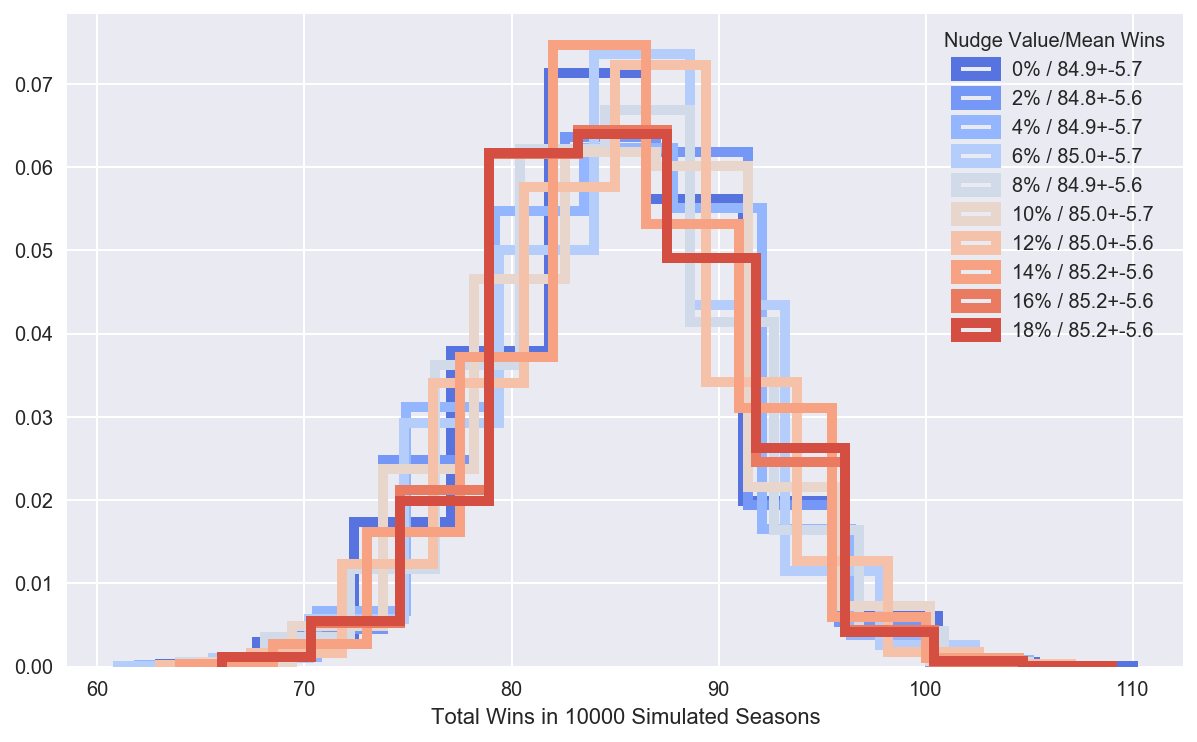

In [242]:
plt.figure(figsize=(10,6))
sns.set_palette(sns.color_palette("coolwarm",len(zero_sum_sims)))
ic = 0
avg_wins = {}
err_wins = {}
for inudge in nudge_vals:
    plt.hist(zero_sum_sims[inudge].standings['AL']['Division_Record']['East'].loc[nudge_team],histtype='step', density=True, linewidth = 5);
    avg_wins[inudge] = np.mean(zero_sum_sims[inudge].standings['AL']['Division_Record']['East'].loc[nudge_team])
    err_wins[inudge] = np.std(zero_sum_sims[inudge].standings['AL']['Division_Record']['East'].loc[nudge_team])
    ic+=1
plt.xlabel('Total Wins in {0} Simulated Seasons'.format(num_season_sims));
plt.legend(['{0}% / {1:.1f}+-{2:.1f}'.format(n, avg_wins[n],err_wins[n]) for n in nudge_vals],title='Nudge Value/Mean Wins');
print("""
    Toronto's average win totals remain around {0:0.0f} +- {1:0.1f} for all nudge levels. 
    """.format(np.median(zero_sum_sims[0].standings['AL']['Division_Record']['East'].loc[nudge_team]),np.std(zero_sum_sims[0].standings['AL']['Division_Record']['East'].loc[nudge_team]) ))

### Check change in probability of Toronto winning the division.  


    Toronto's odds of winning the division rise from 0.23 to 0.28, at the expense of division rivals.
    


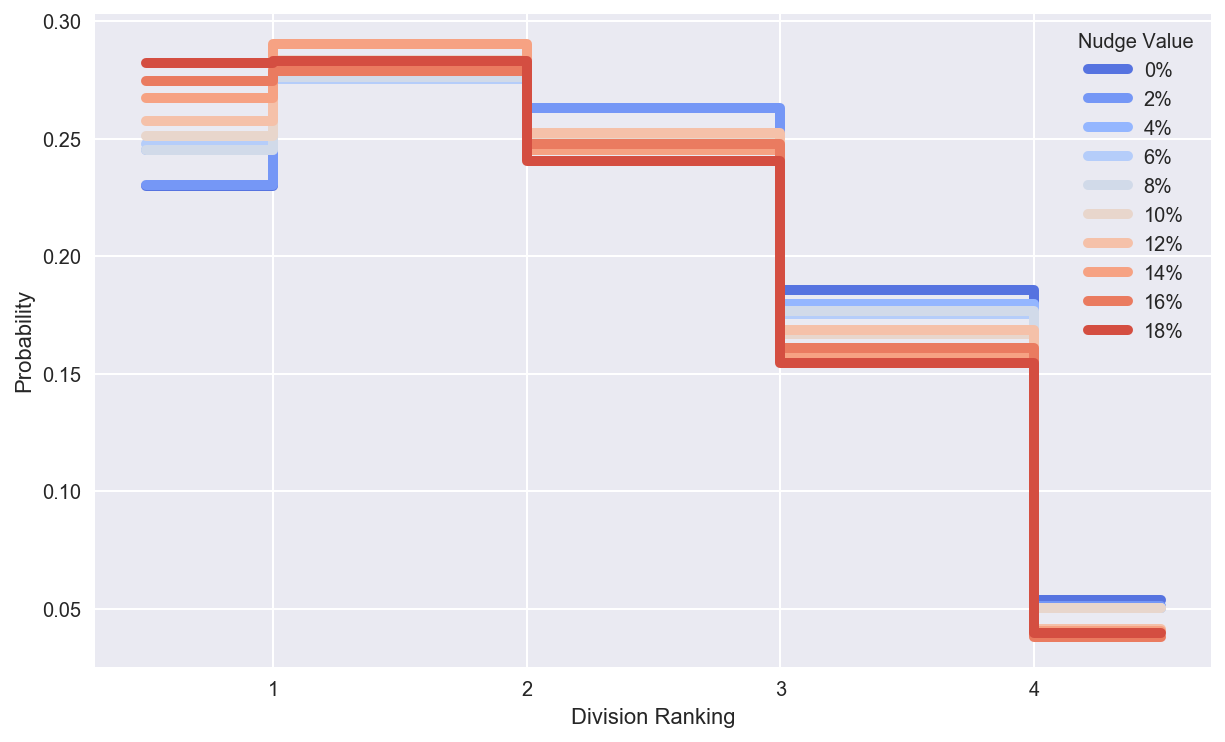

In [239]:
plt.figure(figsize=(10,6))
sns.set_palette(sns.color_palette("coolwarm",len(zero_sum_sims)))
division_win_prob = {}
for inudge in nudge_vals:
    h = np.histogram(zero_sum_sims[inudge].standings['AL']['Division_Rank']['East'].loc[nudge_team]+1,bins = np.arange(6)+.5);
    division_win_prob[inudge] = h[0]/num_season_sims
    x =(h[1][1:]+h[1][:-1])/2 - 0.5
    plt.step(x,division_win_prob[inudge], linewidth = 5,label=str(inudge),where='mid')
plt.xlabel('Division Ranking')
plt.ylabel('Probability');
plt.xticks([1,2,3,4]);
plt.legend([str(n)+'%' for n in nudge_vals],title='Nudge Value');
print("""
    Toronto's odds of winning the division rise from {0:.2f} to {1:.2f}.
    """.format(division_win_prob[nudge_vals[0]][0],division_win_prob[nudge_vals[-1]][0]) )

### Compare odds of making the playoff by winning the division or winning the wild card.



    Toronto's playoff odds rise 4%, from 0.51 to 0.56, which is roughly 
    similar to the odds of winning the division, which rise from 0.26 to 0.31. 
    Wildcard appearances, on the other hand, decrease as more divisions are won, but
    the net playoff appearances is nonetheless still positive.   
    


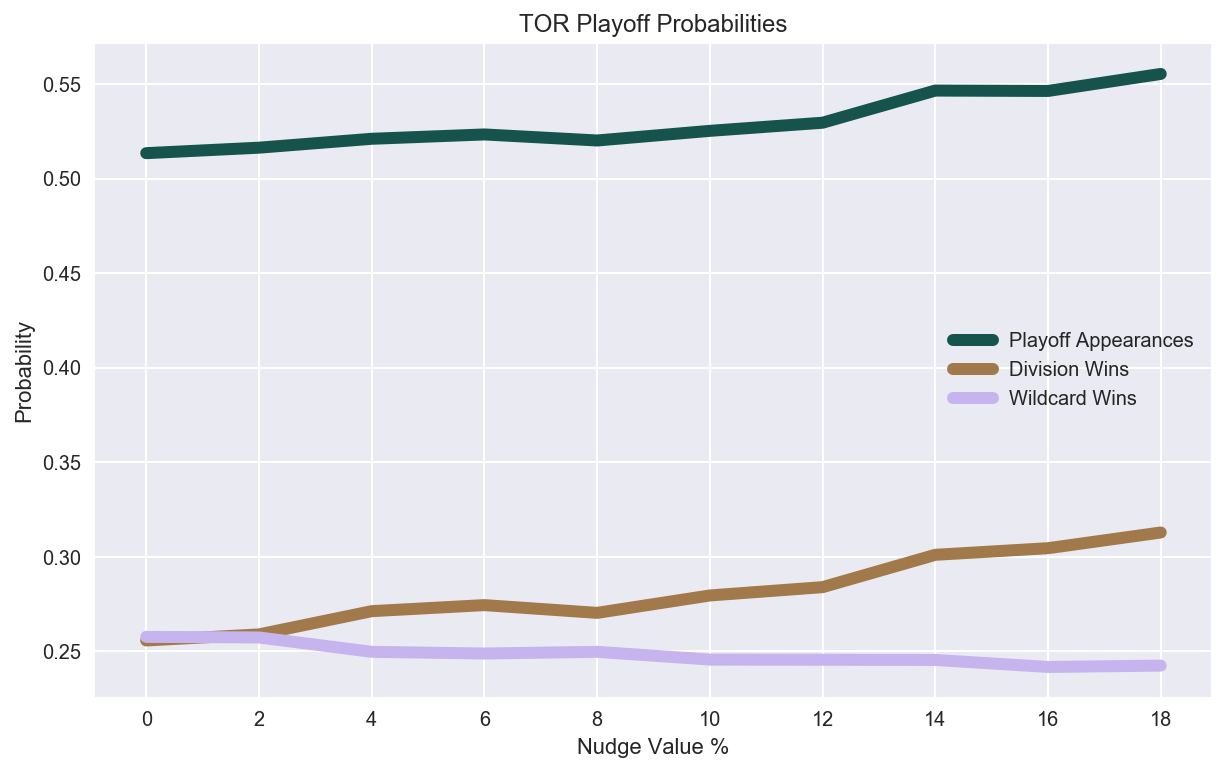

In [240]:
plt.figure(figsize=(10,6))
sns.set_palette(sns.color_palette("cubehelix", 3))
y_playoff_appearance = np.array([zero_sum_sims[i].playoff_appearances['AL'][nudge_team]/num_season_sims for i in nudge_vals])
y_division_wins = np.array([zero_sum_sims[i].division_wins['AL']['East'][nudge_team]/num_season_sims for i in nudge_vals])
y_wild_cards = y_playoff_appearance - y_division_wins

plt.plot(nudge_vals,y_playoff_appearance, linewidth = 6);
plt.plot(nudge_vals,y_division_wins, linewidth = 6);
plt.plot(nudge_vals,y_wild_cards, linewidth = 6);
plt.xlabel('Nudge Value %');
plt.ylabel('Probability');
plt.xticks(nudge_vals);
plt.legend(['Playoff Appearances', 'Division Wins', 'Wildcard Wins']);
plt.title(nudge_team+' Playoff Probabilities');
print("""
    Toronto's playoff odds rise {0:0.0f}%, from {1:.2f} to {2:.2f}, which is roughly 
    similar to the odds of winning the division, which rise from {3:.2f} to {4:.2f}. 
    Wildcard appearances, on the other hand, decrease as more divisions are won, which
    is the result of both the extra beating on wildcard contenders like Baltimore, as 
    well as the decrease in strength of Toronto as an opponent outside of their division.   
    """.format((y_playoff_appearance[-1]-y_playoff_appearance[0])*100,y_playoff_appearance[0],y_playoff_appearance[-1],y_division_wins[0],y_division_wins[-1]))

In [ ]:
# Compare odds of making the playoff by winning the division or winning the wild card.

/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]



    Toronto's playoff odds rise from 0.51 to 0.56, at the expense of Baltimore, Boston, and New York, which drop 
    from 0.45 to 0.42, 0.45 to 0.42, and 0.31 to 0.27, respectively. 
    Interestingly, playoff odds increase for teams in other divisions as well, namely Detroit, since they benefited from the extra losses 
    by key wild-card rival Baltimore in the East.  
    


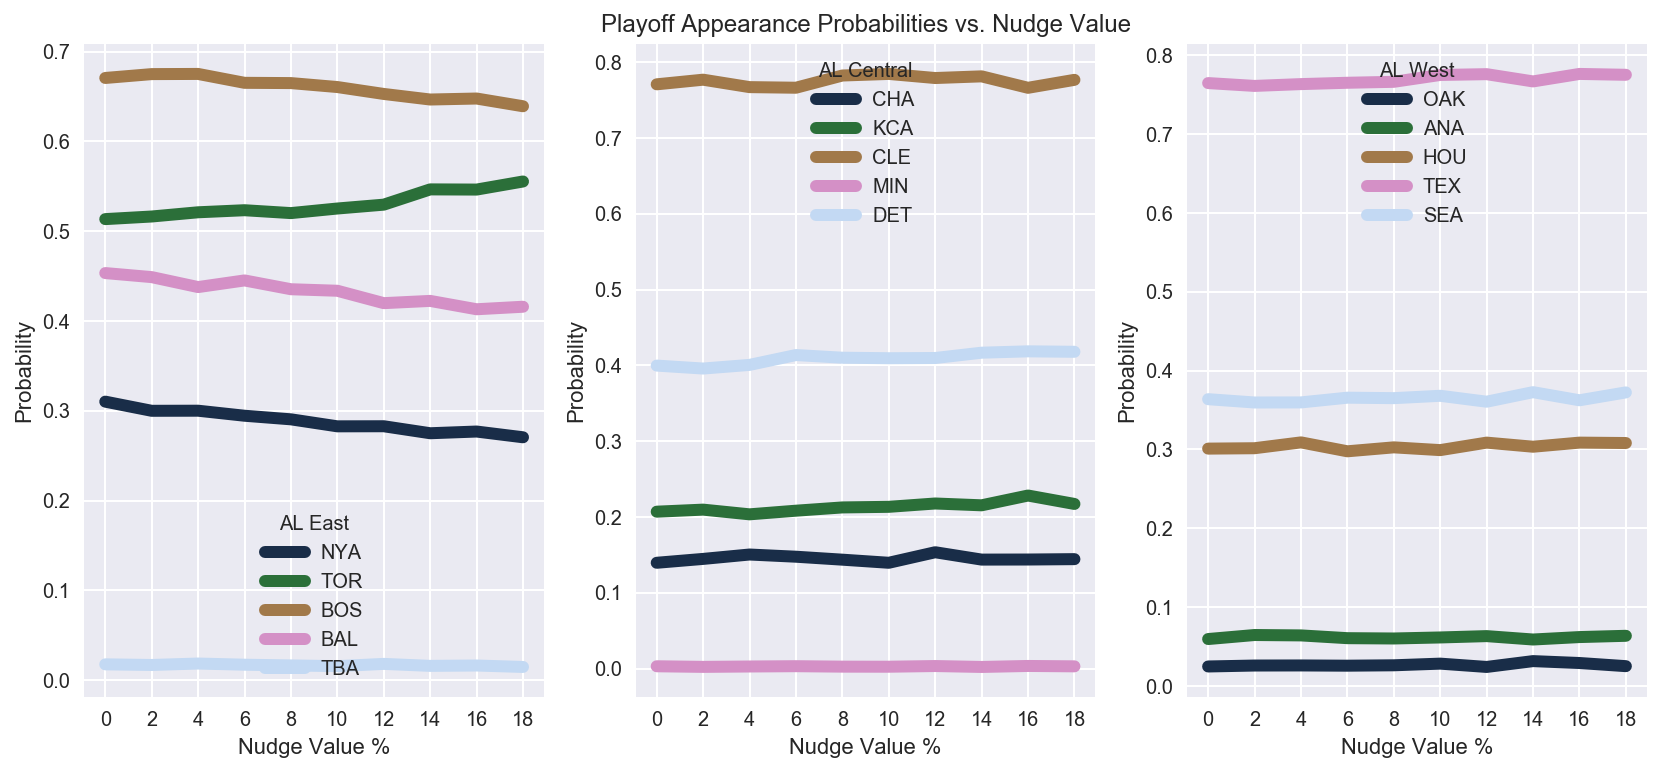

In [246]:
plt.figure(figsize=(14,6))
div_col= {'East':sns.color_palette("cubehelix", 5),
           'Central':sns.color_palette("cubehelix", 5),
           'West':sns.color_palette("cubehelix", 5)}
linestyle = ['-','--',':']
playoff_appearance_probability = {}
Lg = 'AL'
j=131
for divsn in zero_sum_sims[0].leagues[Lg]:
    color = div_col[divsn]
    k = 0
    for iteam in zero_sum_sims[0].leagues[Lg][divsn]:
        plt.subplot(j)
        playoff_appearance_probability[iteam] = np.array([zero_sum_sims[i].playoff_appearances[Lg][iteam]/num_season_sims for i in nudge_vals])
        plt.plot(nudge_vals,playoff_appearance_probability[iteam], linewidth = 6, color=color[k][:], label=iteam);
        k += 1
    j += 1
    plt.xlabel('Nudge Value %');
    plt.ylabel('Probability');
    plt.xticks(nudge_vals);
    plt.legend(title = Lg+' '+divsn);
    if j == 133: plt.title('Playoff Appearance Probabilities vs. Nudge Value');
print("""
    Toronto's playoff odds rise from {0:.2f} to {1:.2f}, at the expense of Baltimore, Boston, and New York, which drop 
    from {2:.2f} to {3:.2f}, {4:.2f} to {5:.2f}, and {6:.2f} to {7:.2f}, respectively. 
    Interestingly, playoff odds increase for teams in other divisions as well, namely Detroit, since they benefited from the extra losses 
    by key wild-card rival Baltimore in the East, and the reduced strength of Toronto, when they play.  
    """.format(playoff_appearance_probability['TOR'][0],playoff_appearance_probability['TOR'][-1],
              playoff_appearance_probability['BAL'][0],playoff_appearance_probability['BAL'][-1],
              playoff_appearance_probability['BAL'][0],playoff_appearance_probability['BAL'][-1],
              playoff_appearance_probability['NYA'][0],playoff_appearance_probability['NYA'][-1]))

## Summary
It's clear that stacking your odds to beat division rivals at the expense of out of division or league can pay off, but is worth the effort?  Wins are valued at something like 10 million dollars, but really, a few wins means much more to a 85 win team than it does to a 75 or 95 win team. <br>
However, randomness is an important component to any single year record, and those extra wins could very well end up making the difference.  Lining up your best starters to play in the division, and giving your best players the day off for interleague, could eventually be standard practise. 

